## Frequency model - Poisson distribution

The number of claims(ClaimNb) is a positive integer (0 included). Thus, this target can be modelled by a Poisson distribution. 

索赔数量（ClaimNb）是一个正整数（包括 0）。因此，这个目标可以用泊松分布来建模。

It is then assumed to be the number of discrete events occurring with a constant rate in a given time interval (Exposure, in units of years). 

然后假设它是在给定时间间隔（以年为单位的风险敞口）内以恒定速率发生的离散事件的数量。

Here we model the frequency y = ClaimNb / Exposure, which is still a (scaled) Poisson distribution, and use Exposure as sample_weight.

在这里，我们对频率 y = ClaimNb / Exposure 进行建模，它仍然是（缩放后的）泊松分布，并将 Exposure 用作样本权重。

In [29]:
import pandas as pd
from functools import partial
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)

def score_estimator(
        estimator,
        x_train,
        x_test,
        y_train,
        y_test,
        target,
        weights,
        tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ('D² explained', None),  # Use default scorer if it exists
        ('mean abs. error', mean_absolute_error),
        ('mean squared error', mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                'mean Tweedie dev p={:.4f}'.format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]
    res = []
    for subset_label, x_df, y_df in [
        ('train', x_train, y_train),
        ('test', x_test, y_test),
    ]:
        y, _weights = y_df[target], y_df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(x_df) * est_sev.predict(x_df)
            else:
                y_pred = estimator.predict(x_df)

            if metric is None:
                if not hasattr(estimator, 'score'):
                    continue
                print('x_df shape: {}, y_df shape: {}'.format(x_df.shape, y_df.shape))
                score = estimator.score(x_df, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)
            
            res.append({'subset': subset_label, 'metric': score_label, 'score': score})

    res = (
        pd.DataFrame(res)
        .set_index(['metric', 'subset'])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )

    return res

In [30]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/insurance_claims_label_feature.csv')

print('df shape: {}'.format(df.shape))
df.head()

df shape: (678013, 91)


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,idx,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,...,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74
0,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
1,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
2,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-1.065404
3,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694
4,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694


In [31]:
columns_x = ['X{}'.format(idx) for idx in range(75)]
df_x = df[columns_x]

print('df_x shape: {}'.format(df_x.shape))
df_x.head()

df_x shape: (678013, 75)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-1.065404
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694


In [32]:
columns_y = ['ClaimNb','Exposure','Area','VehPower','VehAge','DrivAge',
             'BonusMalus','VehBrand','VehGas','Density','Region',
             'ClaimAmount','PurePremium','Frequency','AvgClaimAmount']
df_y = df[columns_y]

print('df_y shape: {}'.format(df_y.shape))
df_y.head()

df_y shape: (678013, 15)


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0
1,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0
2,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,0.0,0.0
3,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0
4,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0


In [33]:
len(df[df['ClaimAmount'] > 0])

24944

In [34]:
from sklearn.model_selection import train_test_split

y_train, y_test, x_train, x_test = train_test_split(df_y, df_x, random_state=0)

print('y_train shape: {}, \t y_test shape: {}, \n x_train shape: {}, \t x_test shape: {}'
      .format(y_train.shape, y_test.shape, x_train.shape, x_test.shape))

y_train shape: (508509, 15), 	 y_test shape: (169504, 15), 
 x_train shape: (508509, 75), 	 x_test shape: (169504, 75)


As a consequence, we expect a significant variability in our evaluation upon random resampling of the train test split.

因此，在对训练测试分割进行随机重采样时，我们预计评估结果会有很大的变异性。

The parameters of the model are estimated by minimizing the Poisson deviance on the training set via a Newton solver. Some of the features are collinear (e.g. because we did not drop any categorical level in the OneHotEncoder), we use a weak L2 penalization to avoid numerical issues.

该模型的参数是通过牛顿求解器在训练集上最小化泊松偏差来估计的。一些特征是共线的（例如，因为我们在 OneHotEncoder 中没有丢弃任何分类级别），我们使用弱 L2 惩罚来避免数值问题。

In [35]:
from sklearn.linear_model import PoissonRegressor

glm_freq = PoissonRegressor(alpha=1e-4, solver='newton-cholesky')
glm_freq.fit(X=x_train, y=y_train['Frequency'], sample_weight=y_train['Exposure'])

scores = score_estimator(
    glm_freq,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    target='Frequency',
    weights='Exposure',
)

print('Evaluation of PoissonRegressor on target Frequency')
print(scores)

x_df shape: (508509, 75), y_df shape: (508509, 15)
x_df shape: (169504, 75), y_df shape: (169504, 15)
Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0448  0.0427
mean abs. error     0.1379  0.1378
mean squared error  0.2441  0.2246


Note that the score measured on the test set is surprisingly better than on the training set. This might be specific to this random train-test split. Proper cross-validation could help us to assess the sampling variability of these results.

请注意，在测试集上测量的得分出人意料地好于在训练集上的得分。这可能是此随机训练 - 测试分割所特有的。适当的交叉验证可以帮助我们评估这些结果的抽样变异性。

We can visually compare observed and predicted values, aggregated by the drivers age (DrivAge), vehicle age (VehAge) and the insurance bonus/malus (BonusMalus).


我们可以直观地比较按驾驶员年龄（DrivAge）、车辆年龄（VehAge）和保险奖惩（BonusMalus）汇总的观测值和预测值。

In [44]:
import matplotlib.pyplot as plt

def plot_obs_pred(
        df,
        feature,
        weight,
        observed,
        predicted,
        y_label=None,
        title=None,
        ax=None,
        fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.
    Parameters
    ----------
    df: DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight: str
        column name of df with the values of weights or exposure
    observed: str
        a column name of df with the observed target
    predicted: DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend: bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_['observed'] = df[observed] * df[weight]
    df_['predicted'] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ['observed', 'predicted']].plot(style='.', ax=ax)
    y_max = df_.loc[:, ['observed', 'predicted']].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color='g',
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ['{} distribution'.format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )

根据观察到的数据，30 岁以下驾驶员的事故频率较高，并且与 BonusMalus(奖惩制度 奖励 / 惩罚，在 50 到 350 之间：在法国，小于 100 意味着奖励，大于 100 意味着惩罚。) 变量呈正相关。我们的模型能够在很大程度上正确地对这种行为进行建模。

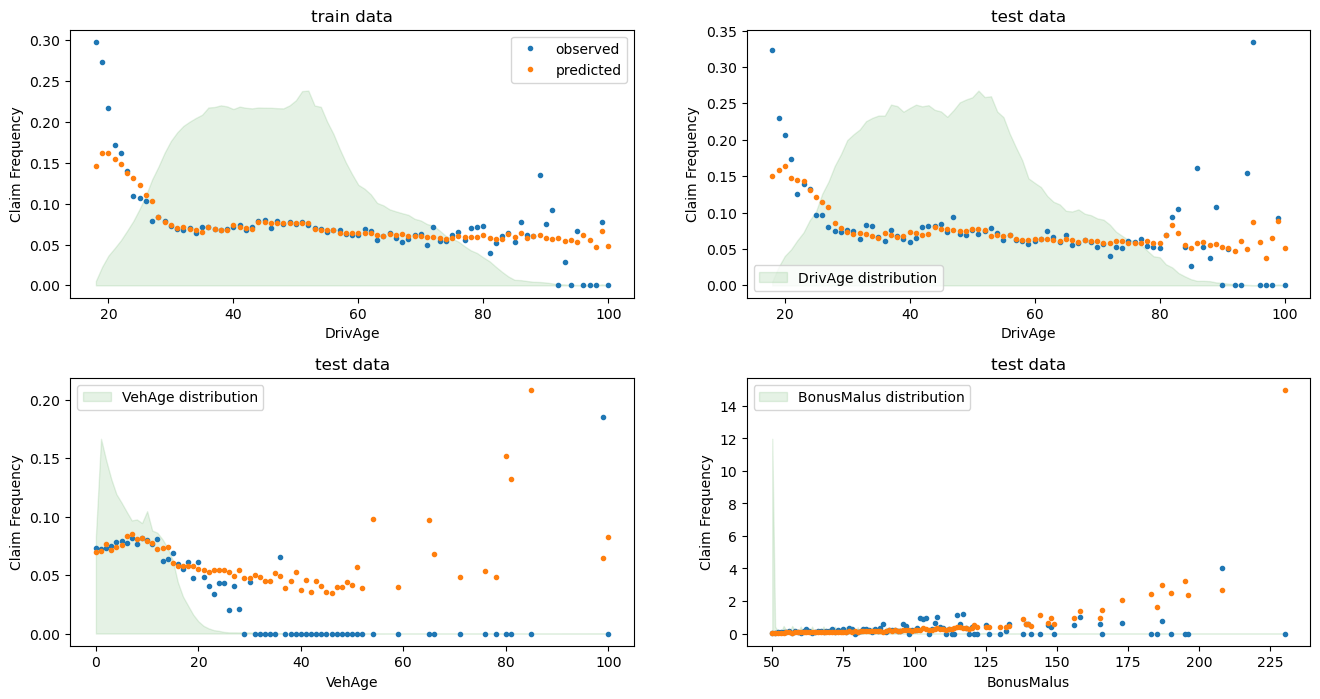

In [45]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=y_train,
    feature='DrivAge',
    weight='Exposure',
    observed='Frequency',
    predicted=glm_freq.predict(x_train),
    y_label='Claim Frequency',
    title='train data',
    ax=ax[0, 0],
)

plot_obs_pred(
    df=y_test,
    feature='DrivAge',
    weight='Exposure',
    observed='Frequency',
    predicted=glm_freq.predict(x_test),
    y_label='Claim Frequency',
    title='test data',
    ax=ax[0, 1],
    fill_legend=True,
)

plot_obs_pred(
    df=y_test,
    feature='VehAge',
    weight='Exposure',
    observed='Frequency',
    predicted=glm_freq.predict(x_test),
    y_label='Claim Frequency',
    title='test data',
    ax=ax[1, 0],
    fill_legend=True,
)

plot_obs_pred(
    df=y_test,
    feature='BonusMalus',
    weight='Exposure',
    observed='Frequency',
    predicted=glm_freq.predict(x_test),
    y_label='Claim Frequency',
    title='test data',
    ax=ax[1, 1],
    fill_legend=True,
)

## Severity Model - Gamma distribution

The mean claim amount or severity (AvgClaimAmount) can be empirically shown to follow approximately a Gamma distribution. We fit a GLM model for the severity with the same features as the frequency model.

In [47]:
from sklearn.linear_model import GammaRegressor

mask_train = y_train['ClaimAmount'] > 0
mask_test = y_test['ClaimAmount'] > 0

In [48]:
print(mask_train)

459726    False
188486    False
436803    False
87956     False
291065    False
          ...  
359783    False
152315    False
117952    False
435829    False
305711    False
Name: ClaimAmount, Length: 508509, dtype: bool


In [50]:
glm_sev = GammaRegressor(alpha=10.0, solver='newton-cholesky')

glm_sev.fit(
    x_train[mask_train.values],
    y_train.loc[mask_train, 'AvgClaimAmount'],
    sample_weight=y_train.loc[mask_train, 'ClaimNb'],
)

scores = score_estimator(
    glm_sev,
    x_train=x_train[mask_train.values],
    x_test=x_test[mask_test.values],
    y_train=y_train[mask_train],
    y_test=y_test[mask_test],
    target='AvgClaimAmount',
    weights='ClaimNb',
)
print('Evaluation of GammaRegressor on target AvgClaimAmount')
print(scores)

x_df shape: (18707, 75), y_df shape: (18707, 15)
x_df shape: (6237, 75), y_df shape: (6237, 15)
Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        3.900000e-03  4.400000e-03
mean abs. error     1.756746e+03  1.744042e+03
mean squared error  5.801770e+07  5.030677e+07


Those values of the metrics are not necessarily easy to interpret. 

这些指标的值不一定容易解释。

It can be insightful to comapre them with a model that does not use any input features and always predicts a constant value, i.e. the average claim amount, in the same setting:

在相同的设置下，将它们与不使用任何输入特征并且总是预测一个恒定值（即平均索赔金额）的模型进行比较可能会很有启发性：

In [51]:
from sklearn.dummy import DummyRegressor

dummy_sev = DummyRegressor(strategy='mean')
dummy_sev.fit(
    x_train[mask_train.values],
    y_train.loc[mask_train, 'AvgClaimAmount'],
    sample_weight=y_train.loc[mask_train, 'ClaimNb'],
)

scores = score_estimator(
    dummy_sev,
    x_train=x_train[mask_train.values],
    x_test=x_test[mask_test.values],
    y_train=y_train[mask_train],
    y_test=y_test[mask_test],
    target='AvgClaimAmount',
    weights='ClaimNb',
)
print('Evaluation of a mean predictor on target AvgClaimAmount')
print(scores)

x_df shape: (18707, 75), y_df shape: (18707, 15)
x_df shape: (6237, 75), y_df shape: (6237, 15)
Evaluation of a mean predictor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        0.000000e+00 -0.000000e+00
mean abs. error     1.756687e+03  1.744497e+03
mean squared error  5.803882e+07  5.033764e+07


We conclude that the claim amount is very challenging to predict.
我们的结论是，索赔金额很难预测。

Still, the GammaRegressor is able to leverage some information from the input features to slightly improve upon the mean baseline in terms of D^2.
尽管如此，GammaRegressor 仍然能够利用来自输入特征的一些信息来稍微改进 D^2 的平均基线。

Nont that the resulting model is the average claim amount per claim.
结果模型不是每个索赔的平均索赔额。

As such, it is conditional on having at least one claim, and cannot be used to predict the average claim amount per policy.
因此，它以至少有一项索赔为条件，不能用于预测每份保单的平均索赔金额。

For this, it needs to be combined with a claims frequency model.
为此，它需要与索赔频率模型相结合。


In [53]:
print('Mean AvgClaim Amount per policy: %.2f ' % y_train['AvgClaimAmount'].mean())
print('Mean AvgClaim Amount | NbClaim > 0: %.2f ' % y_train['AvgClaimAmount'][y_train['AvgClaimAmount'] > 0].mean())
print('Predicted Mean AvgClaim Amount | NbClaim > 0: %.2f' % glm_sev.predict(x_train).mean())
print('Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: %.2f' % dummy_sev.predict(x_train).mean())

Mean AvgClaim Amount per policy: 71.78 
Mean AvgClaim Amount | NbClaim > 0: 1951.21 
Predicted Mean AvgClaim Amount | NbClaim > 0: 1940.95
Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: 1978.59


We can visually compare observed and predicted values, aggregated for the drivers age(`DrivAge`).

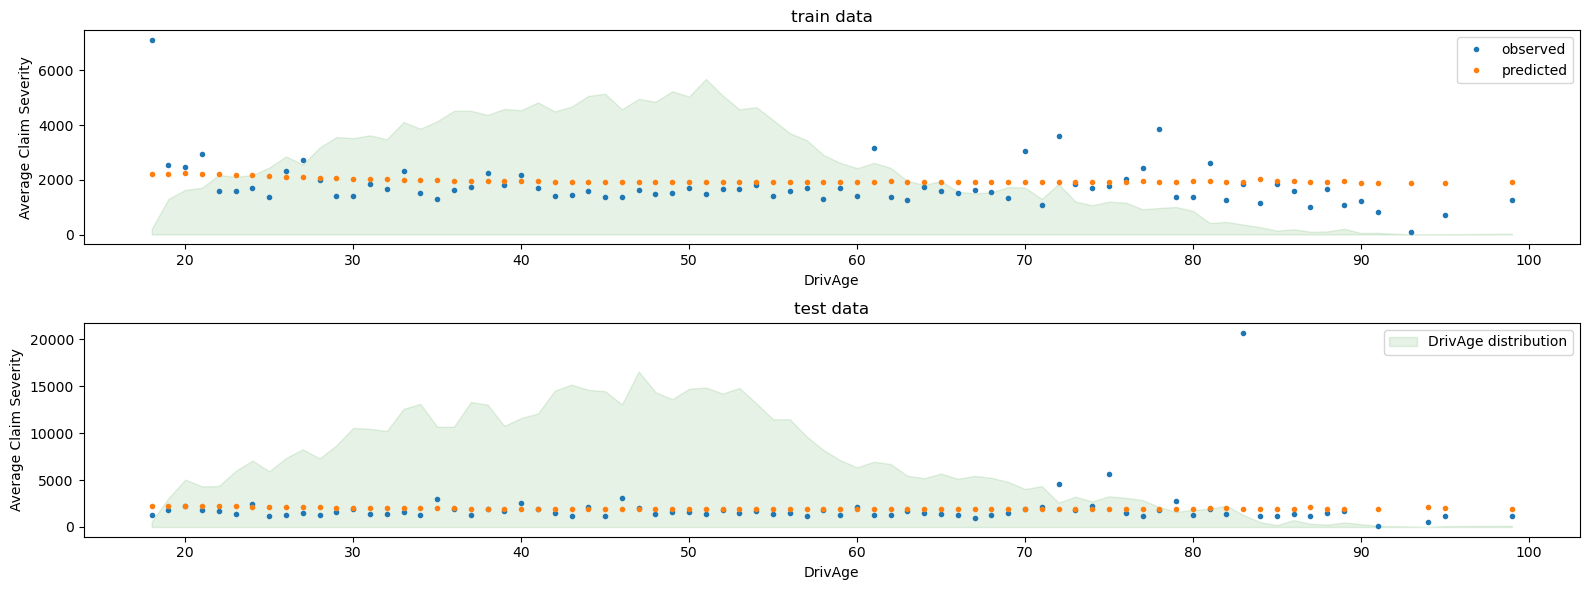

In [55]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=y_train.loc[mask_train],
    feature='DrivAge',
    weight='Exposure',
    observed='AvgClaimAmount',
    predicted=glm_sev.predict(x_train[mask_train.values]),
    y_label='Average Claim Severity',
    title='train data',
    ax=ax[0],
)

plot_obs_pred(
    df=y_test.loc[mask_test],
    feature='DrivAge',
    weight='Exposure',
    observed='AvgClaimAmount',
    predicted=glm_sev.predict(x_test[mask_test.values]),
    y_label='Average Claim Severity',
    title='test data',
    ax=ax[1],
    fill_legend=True,
)
plt.tight_layout()

Overall, the drivers age(DrivAge) has a week impact on the claim severity, both in observed and predicted data.

总的来说，司机年龄（驾驶年龄）对索赔严重程度有一周的影响，无论是在观察到的还是预测的数据中。